<a href="https://www.kaggle.com/code/igortrevelin/german-credit-risk?scriptVersionId=131644854" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# German Credit Risk

![](https://images.unsplash.com/photo-1633158829585-23ba8f7c8caf?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=600&q=80)

### Table of Contents
* [Required Libraries and Data](#libs)
* [Data Analysis](#data-analysis)
    * [Gender Analysis](#gender)
    * [Risk Analysis](#risk-analysis)
* [Data Preprocessing and Feature Engineering](#dataprep)
    * [Outlier Detection](#outlier)
    * [Feature Encoding](#encoding)
    * [Standardization](#standardization)
    * [Correlation Analysis](#correlation)
* [Modeling](#modeling)
    * [Hyperparameter Tuning](#tuning)
        * [Naive Bayes](#nb)
        * [Decision Tree](#cart)
        * [XGBoost](#xgboost)
        * [LightGBM](#lgbm)

# <a id="libs"></a>Required Libraries and Data:

In [1]:
import math

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

import random
seed = 42
random.seed(seed)
np.random.seed(seed)

sns.set_style("darkgrid")
pd.set_option("display.max_columns", 9999)

In [2]:
df = pd.read_csv("../input/german-credit-data-with-risk/german_credit_data.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [4]:
df.shape

(1000, 10)

In [5]:
df.isnull().sum().sort_values(ascending=False)

Checking account    394
Saving accounts     183
Age                   0
Sex                   0
Job                   0
Housing               0
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
columns = df.columns.to_list()
for col in columns:
    unique_values = df[col].unique()
    numeric = pd.api.types.is_numeric_dtype(df[col])
    print(f"{col} ({df[col].dtype})")
    
    if numeric:
        unique_values = np.sort(unique_values)
        
    if numeric and len(unique_values) > 20:
        print(unique_values[:10], " ... ", unique_values[-10:])
    else:
        print(unique_values)
        
    print("\n")

Age (int64)
[19 20 21 22 23 24 25 26 27 28]  ...  [62 63 64 65 66 67 68 70 74 75]


Sex (object)
['male' 'female']


Job (int64)
[0 1 2 3]


Housing (object)
['own' 'free' 'rent']


Saving accounts (object)
[nan 'little' 'quite rich' 'rich' 'moderate']


Checking account (object)
['little' 'moderate' nan 'rich']


Credit amount (int64)
[250 276 338 339 343 362 368 385 392 409]  ...  [14318 14421 14555 14782 14896 15653 15672 15857 15945 18424]


Duration (int64)
[ 4  5  6  7  8  9 10 11 12 13]  ...  [36 39 40 42 45 47 48 54 60 72]


Purpose (object)
['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


Risk (object)
['good' 'bad']




In [8]:
df["Saving accounts"] = df["Saving accounts"].fillna("none")
df["Checking account"] = df["Checking account"].fillna("none")

In [9]:
df["Job"] = df["Job"].map({
    0: "unskilled and non-resident",
    1: "unskilled and resident",
    2: "skilled",
    3: "highly skilled"
})

In [10]:
numeric_features = df.select_dtypes(include=[int, float]).columns.to_list()
categorical_features = list(set(df.drop("Risk", axis=1).columns) - set(numeric_features))

# <a id="data-analysis"></a>Data Analysis:
In this section we will perform data analysis from different groups perspectives in order to find _insights_ about our data.

## <a id="gender"></id>Gender Analysis:

**Objectives**:
* Find the distribution of genders in the dataset.
* See the age distribution for each gender.
* What are the main reasons for loans (purposes)? Does it vary by gender?
* What is the proportion of male and females for each job skill level?

**Findings:**
* The male/female proportion is 69%/31% respectively.
* Considering a lifetime span, females tend to make loan sooner than males.
* The main reasons for loans area car and radio/tv.

In [11]:
df["Sex"].value_counts(normalize=True)

male      0.69
female    0.31
Name: Sex, dtype: float64

In [12]:
fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{"colspan": 2}, None]], subplot_titles=("Males", "Females", "All Genders"))

male_age = df.loc[df["Sex"] == "male", "Age"]
female_age = df.loc[df["Sex"] == "female", "Age"]

trace0 = go.Histogram(
    x=male_age,
    histnorm="percent",
    name="Male",
    marker=dict(
        color="rgba(0, 87, 233, 0.6)"
    )
)

trace1 = go.Histogram(
    x=female_age,
    histnorm="percent",
    name="Female",
    marker=dict(
        color="rgba(255, 0, 189, 0.6)"
    )
)

trace2 = go.Histogram(
    x=df["Age"],
    histnorm="percent",
    name="All Genders",
    marker=dict(
        color="rgba(242, 202, 25, 0.6)"
    )
)

fig.append_trace(trace0, row=1, col=1)
fig.append_trace(trace1, row=1, col=2)
fig.append_trace(trace2, row=2, col=1)
fig.update_layout(title="Distribution of Age by Gender", title_x=0.5, showlegend=True, bargap=0.05, width=1200)

fig.show()

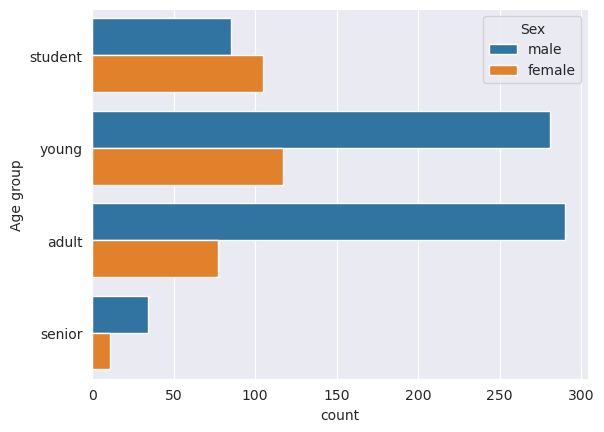

In [13]:
labels = ("student", "young", "adult", "senior")
groups = pd.cut(df["Age"], labels=labels, bins=(18, 25, 35, 60, 120), ordered=True)
df["Age group"] = groups

sns.countplot(data=df, y="Age group", hue="Sex")
plt.show()

In [14]:
fig = px.histogram(data_frame=df, x="Purpose", color="Sex", histnorm="percent", barmode="group", width=800)
fig.update_layout(title="Distribution of Purpose by Sex", title_x=0.5)
fig.show()

In [15]:
fig = px.box(data_frame=df, x="Purpose", y="Credit amount", color="Sex", width=900)
fig.update_layout(title="Credit amount by Purpose and Risk", title_x=0.5)
fig.show()

## <a id="risk-analysis"></a>Risk Analysis

**Objectives and Answers:**:
* Does the credit amount and duration influence the credit risk?
* Are rich people less probable becoming a loan defaulter?
* Does the age influence the credit risk?
* Does the gender influence the credit risk?

**Findings:**
* Credit with higher amount and duration has a greater risk becoming a bad credit.
* Rich people are less probable of becoming bad credit.
* Young (20-30) and old (60+) have a slightly greater chance becoming credit defaulter.

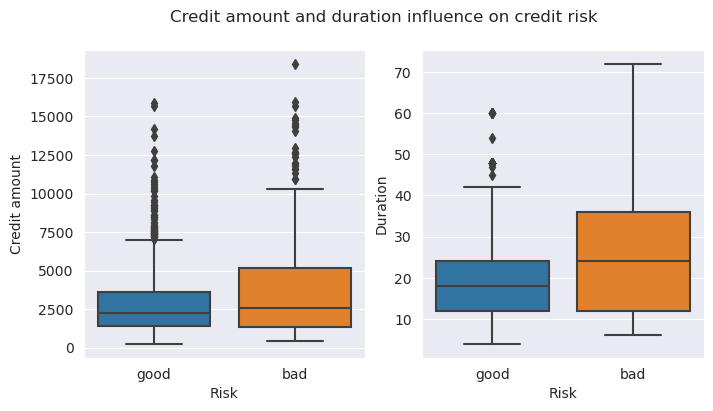

In [16]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=df, x="Risk", y="Credit amount", ax=ax0)
sns.boxplot(data=df, x="Risk", y="Duration", ax=ax1)
fig.suptitle("Credit amount and duration influence on credit risk")
fig.show()

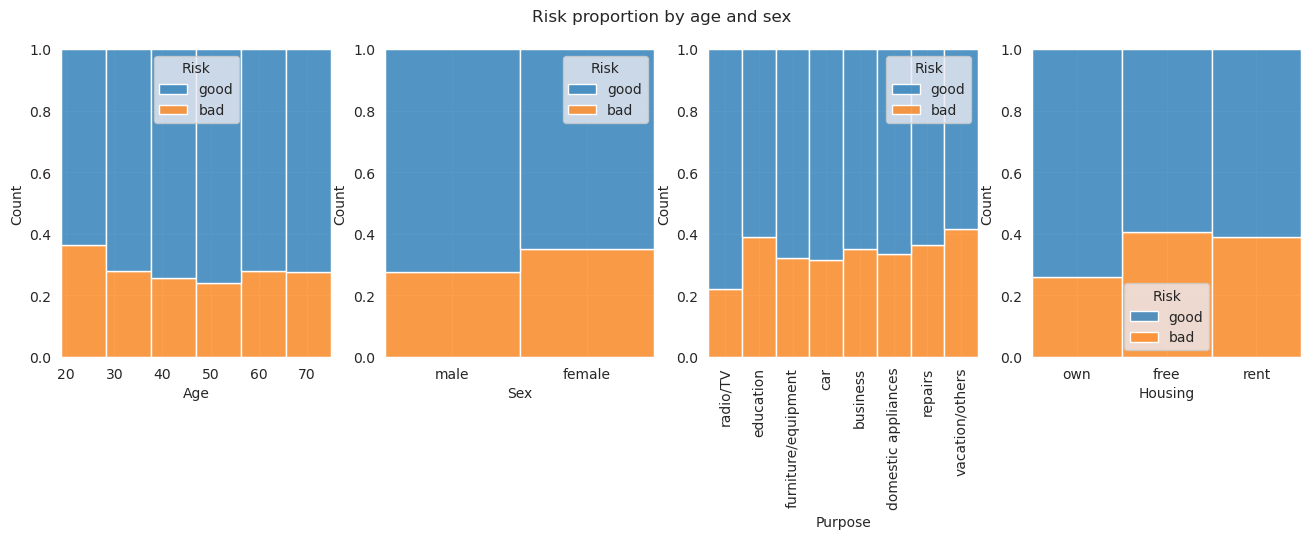

In [17]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16, 4))
sns.histplot(data=df, x="Age", hue="Risk", multiple="fill", bins=6, ax=ax0)
sns.histplot(data=df, x="Sex", hue="Risk", multiple="fill", ax=ax1)
sns.histplot(data=df, x="Purpose", hue="Risk", multiple="fill", ax=ax2)
sns.histplot(data=df, x="Housing", hue="Risk", multiple="fill", ax=ax3)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation= 90)
fig.suptitle("Risk proportion by age and sex")
plt.show()

# <a id="dataprep"></a>Data Preprocessing and Feature Engineering

In [18]:
df["Age_gt_median"] = df["Age"].map(lambda x: (x >= df["Age"].median()).astype(int))
df["Duration_gt_median"] = df["Duration"].map(lambda x: (x >= df["Duration"].median()).astype(int))
df["Credit_amount_gt_median"] = df["Credit amount"].map(lambda x: (x >= df["Credit amount"].median()).astype(int))

In [19]:
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk', 'Age group',
       'Age_gt_median', 'Duration_gt_median', 'Credit_amount_gt_median'],
      dtype='object')

In [20]:
df_pre = df.copy()

## <a id="outlier"></a>Outlier Detection

In [21]:
def get_outliers(df, feature, iqr_threshold=1.5):
    q1 = np.percentile(df[feature], 25)
    q3 = np.percentile(df[feature], 75)
    iqr = q3 - q1
    return df[(df[feature] < (q1 - iqr_threshold * iqr)) | (df[feature] > (q3 + iqr_threshold * iqr))]

numeric_features = df_pre.select_dtypes(include=[int, float]).columns.to_list()
for feature in numeric_features:
    nouts = len(get_outliers(df_pre, feature))
    if nouts > 0:
        print("%s: %d" % (feature, nouts))

Age: 23
Credit amount: 72
Duration: 70


## <a id="encoding"></a>Feature Encoding
We have 8 categorical features that need to be encoded.

In [22]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(drop="first", sparse=False)
onehot_features = ["Sex", "Job", "Housing", "Saving accounts", "Checking account", "Purpose", "Risk", "Age group"]
X_onehot = onehot.fit_transform(df_pre[onehot_features])
df_onehot = pd.DataFrame(data=X_onehot, columns=onehot.get_feature_names_out(onehot.feature_names_in_))
df_onehot.head()

,Sex_male,Job_skilled,Job_unskilled and non-resident,Job_unskilled and resident,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_none,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_none,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_good,Age group_senior,Age group_student,Age group_young
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
df_pre = df.drop(onehot_features, axis=1)
df_pre = pd.concat((df_pre, df_onehot), axis=1)

Now we will transform Risk_good into Risk_bad to keep our event of interest encoded as the positive class.

In [24]:
df_pre["Risk_bad"] = (df_pre["Risk_good"] + 1) % 2
df_pre.drop(["Risk_good"], axis=1, inplace=True)

## <a id="standardization"></a>Standardization

Standardization of the dataset is a common requirement for many machine learning estimators, so we will apply robust scaling to our data. The robust scaling method scales the data according to a specified quantile range, being a scaling method robust to outliers.

In [25]:
df_pre.columns

Index(['Age', 'Credit amount', 'Duration', 'Age_gt_median',
       'Duration_gt_median', 'Credit_amount_gt_median', 'Sex_male',
       'Job_skilled', 'Job_unskilled and non-resident',
       'Job_unskilled and resident', 'Housing_own', 'Housing_rent',
       'Saving accounts_moderate', 'Saving accounts_none',
       'Saving accounts_quite rich', 'Saving accounts_rich',
       'Checking account_moderate', 'Checking account_none',
       'Checking account_rich', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others', 'Age group_senior',
       'Age group_student', 'Age group_young', 'Risk_bad'],
      dtype='object')

In [26]:
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

to_scale_columns = ["Age", "Credit amount", "Duration"]
transformer = ColumnTransformer(transformers=[
    ("robust_scaler", RobustScaler(), to_scale_columns)
])
df_pre.loc[:, to_scale_columns] = transformer.fit_transform(df_pre)

## <a id="correlation"></a>Correlation Analysis

Let's look the correlation matrix to see the linear relationships between our variables.

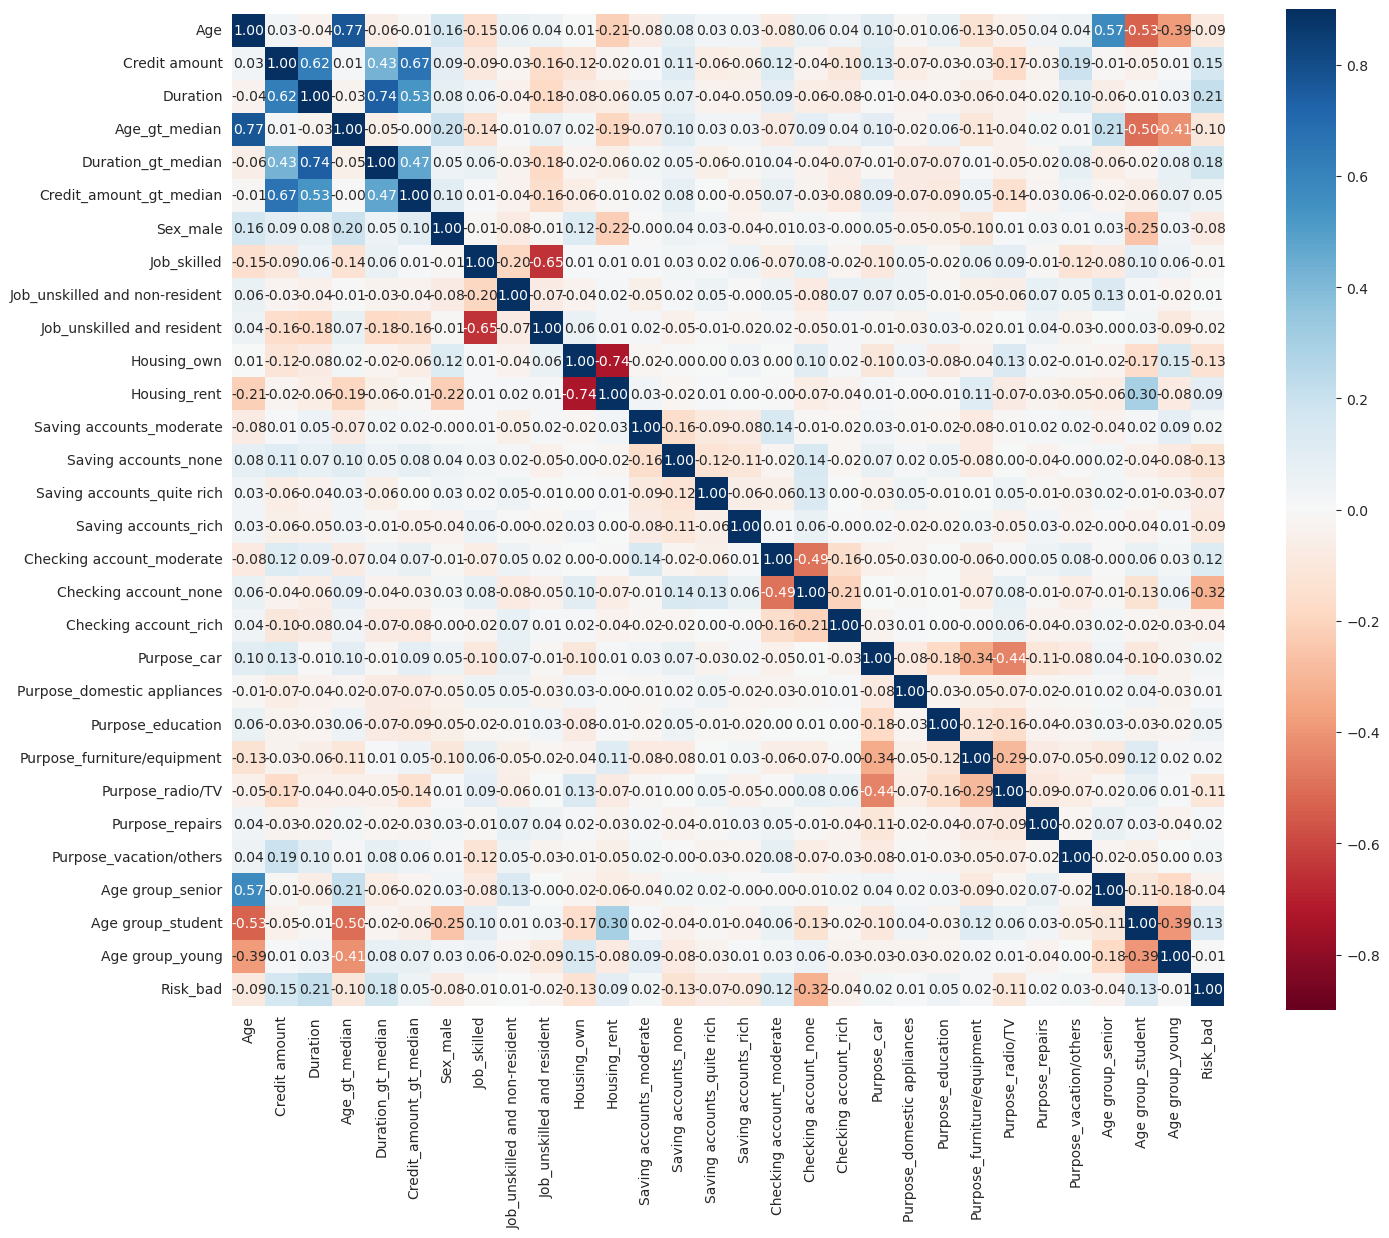

In [27]:
corr = df_pre.corr()
plt.figure(figsize=(16, 13))
sns.heatmap(corr, annot=True, square=True, fmt=".2f", cmap="RdBu", vmin=-0.9, vmax=0.9)
plt.show()

As can be seen in the heatmap above, most of the relevant correlations are between one-hot encoded features derivated from the same variable.

# <a id="modeling"></a>Modeling

In [28]:
from sklearn.model_selection import train_test_split

X = df_pre.drop("Risk_bad", axis=1)
y = df_pre["Risk_bad"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")

X_train: (800, 29)
X_test: (200, 29)


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


models = {
    "LR": LogisticRegression(random_state=seed, max_iter=10000),
    "CART": DecisionTreeClassifier(random_state=seed),
    "NB": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "RF": RandomForestClassifier(random_state=seed),
    "SVM": SVC(random_state=seed),
    "XGB": XGBClassifier(),
    "LGBM": LGBMClassifier()
}

scoring = "recall"
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores = []

for name, model in models.items():
    _scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=kfold, n_jobs=-1)
    msg = "%s has an average score of %.3f ± %.3f" % (name, np.mean(_scores), np.std(_scores))
    print(msg)
    scores.append(_scores)

LR has an average score of 0.361 ± 0.120
CART has an average score of 0.473 ± 0.088
NB has an average score of 0.606 ± 0.122
KNN has an average score of 0.390 ± 0.086
RF has an average score of 0.365 ± 0.111
SVM has an average score of 0.274 ± 0.103
XGB has an average score of 0.435 ± 0.116
LGBM has an average score of 0.435 ± 0.113


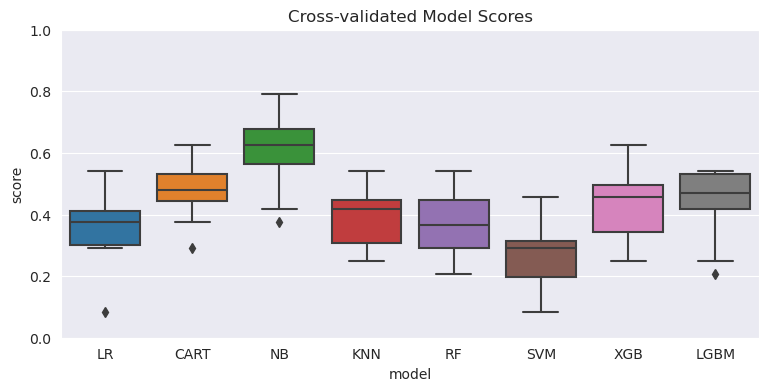

In [30]:
scores_df = pd.DataFrame(data=np.array(scores), index=list(models.keys())).reset_index().rename(columns=dict(index="model"))
scores_df = pd.melt(scores_df, id_vars=["model"], value_vars=np.arange(0, 10)).rename(columns=dict(variable="fold", value="score"))

plt.figure(figsize=(9, 4))
sns.boxplot(data=scores_df, x="model", y="score")
plt.title("Cross-validated Model Scores")
plt.ylim((0, 1))
plt.show()

Looks like the Naive Bayes, Decision Tree, LightGBM and XGBoost models were the bests methods. Now we will perform hyperparameter tuning on each one of them in order to improve their performances.

## <a id="tuning"></a>Hyperparameter Tuning

In [31]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    return accuracy, precision, recall, f1, roc_auc

def print_metrics(y_true, y_pred):
    accuracy, precision, recall, f1_score, roc_auc = metrics(y_true, y_pred)
    print("Accuracy: %.3f\nPrecision: %.3f\nRecall: %.3f\nF1 Score: %.3f\nROC AUC: %.3f" % (accuracy, precision, recall, f1_score, roc_auc))

def plot_curves(y_true, probas):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    precision, recall, thresholds = precision_recall_curve(y_true, probas)
    plt.plot(recall, precision, color="b")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

    plt.subplot(122)
    fpr, tpr, tresholds = roc_curve(y_true, probas)
    plt.plot(fpr, tpr, color="g")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    fig.show()
    
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

### <a id="nb"></a>Naive Bayes

Accuracy: 0.635
Precision: 0.408
Recall: 0.525
F1 Score: 0.459
ROC AUC: 0.603


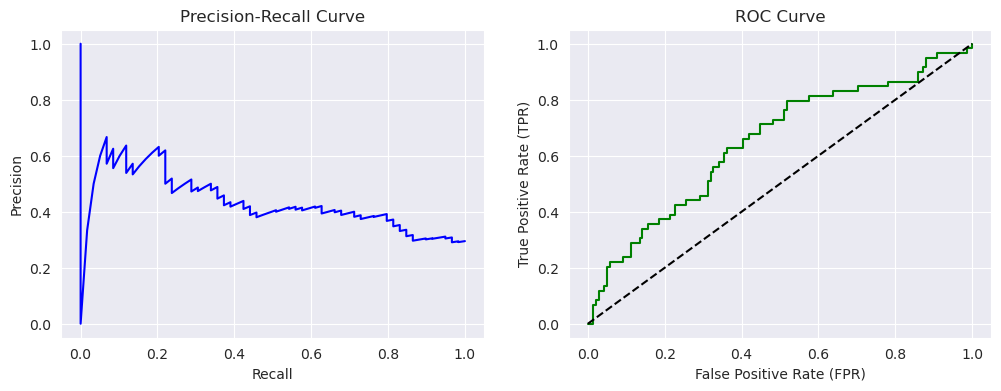

In [32]:
model = GaussianNB()
model.fit(X_train, y_train)
probas = model.predict_proba(X_test)
print_metrics(y_test, model.predict(X_test))
plot_curves(y_test, probas[:, 1])

### <a id="cart"></a>Decision Tree

Accuracy: 0.745
Precision: 0.571
Recall: 0.542
F1 Score: 0.557
ROC AUC: 0.686


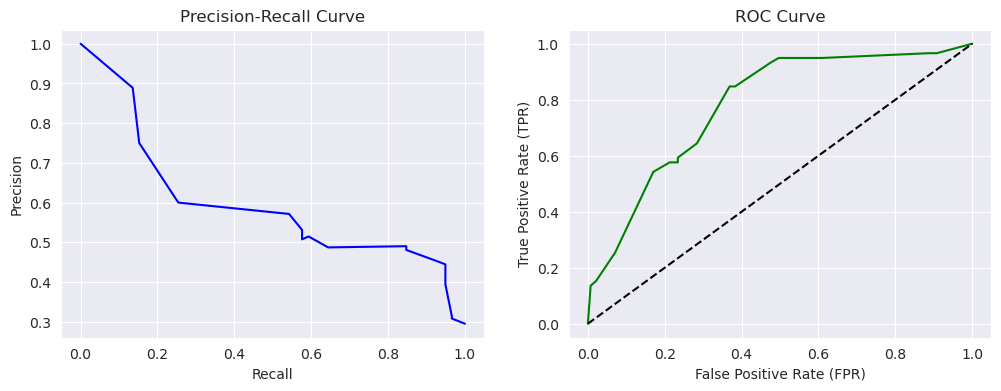

In [33]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier(random_state=seed)
gscv = GridSearchCV(
    model,
    param_grid={
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": np.arange(2, 6),
        "min_samples_split": np.arange(2, 100, 10),
        "max_features": ["sqrt", "log2", None]
    },
    scoring="recall",
    cv=kfold,
    n_jobs=-1
)
gscv.fit(X_train, y_train)
model = gscv.best_estimator_
probas = model.predict_proba(X_test)
print_metrics(y_test, model.predict(X_test))
plot_curves(y_test, probas[:, 1])

### <a id="xgboost"></a>XGBoost

Accuracy: 0.750
Precision: 0.636
Recall: 0.356
F1 Score: 0.457
ROC AUC: 0.635


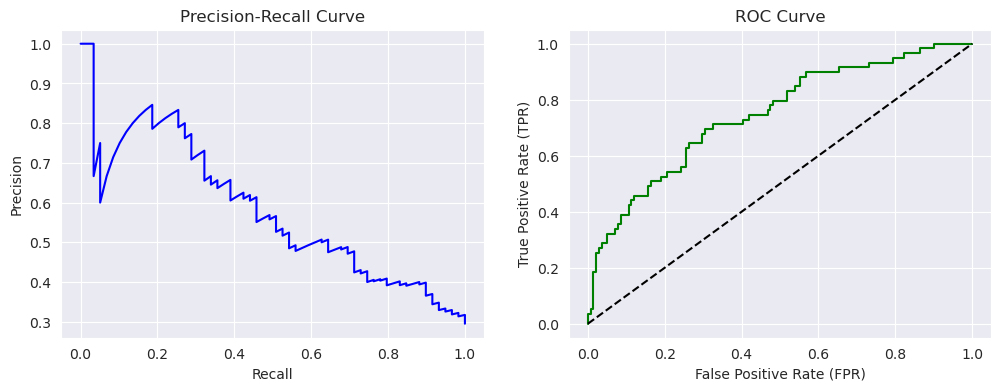

In [34]:
model = XGBClassifier()
gscv = GridSearchCV(
    model,
    param_grid={
        "max_depth": np.arange(2, 6)
    },
    scoring="recall",
    cv=kfold,
    n_jobs=-1
)
gscv.fit(X_train, y_train)
model = gscv.best_estimator_
probas = model.predict_proba(X_test)
print_metrics(y_test, model.predict(X_test))
plot_curves(y_test, probas[:, 1])

### <a id="lgbm"></a>LightGBM

Accuracy: 0.750
Precision: 0.636
Recall: 0.356
F1 Score: 0.457
ROC AUC: 0.635


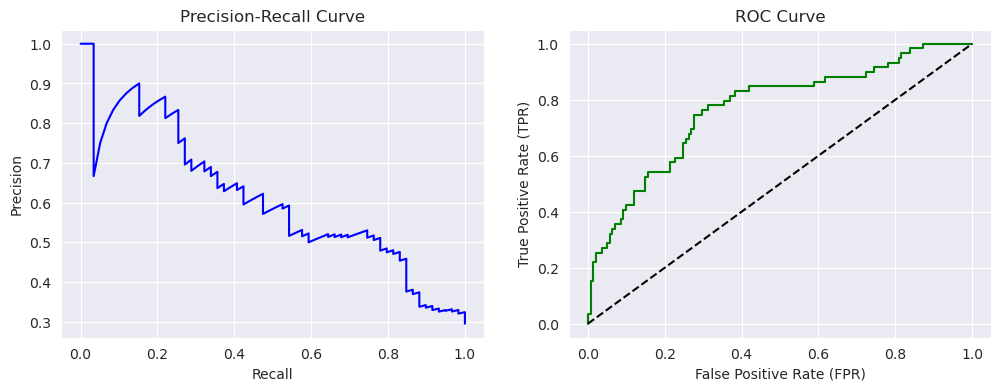

In [35]:
model = LGBMClassifier()
gscv = GridSearchCV(
    model,
    param_grid={
        "max_depth": np.arange(2, 6)
    },
    scoring="recall",
    cv=kfold,
    n_jobs=-1
)
gscv.fit(X_train, y_train)
model = gscv.best_estimator_
probas = model.predict_proba(X_test)
print_metrics(y_test, model.predict(X_test))
plot_curves(y_test, probas[:, 1])